# **Proyecto Integrador: Clasificación**

Diseñar e implementar un modelo predictivo con aprendizaje supervisado para problemas de regresión polinomial multivariada (Usar los datos Engine behavior, Concrete Compressive Strength y Gas Turbine Emission) y **clasificación polinomial multivariada (Usar los datos Microchips, Breast cancer y Dermatology)**, que incluya mas de un algoritmo de entrenamiento asignado por equipo (SGD, GDX, Rprop, RMSprop, RAdam, Adamax, Adam, Adadelta, AdamW, Adagrad, ...); técnicas de regularización (L1, L2, ...); parada temprana de entrenamiento; pre-procesamiento de datos (normalización, selección de tasas de entrenamiento, validación y prueba); formas de aprendizaje (online, batch y minibatch); métricas de desempeño (regresión: SSE, MSE, RMSE y R2; clasificación: matriz de confusion, ROC, Entropia cruzada binaria y entropia cruzada categorica).

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
def normalize_data(X):
  scaler = StandardScaler()
  X_normalized = scaler.fit_transform(X)
  return X_normalized

In [ ]:
def designMatrix(degree, dataInputs):
  poly = PolynomialFeatures(degree)
  return poly.fit_transform(dataInputs)

In [ ]:
def Jacobian(A, e):
  q, m = e.shape
  Je = None
  for j in range(m):
    if Je is None:
      Je = -A
    else:
      Je = block_diag(Je, -A)
  gX = (Je.T @ e.flatten(order="F")) / q
  normgX = np.linalg.norm(gX)
  return gX, normgX, Je

In [ ]:
# Softmax function for hypothesis
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [ ]:
def classCostPerf_lm(A, Y, theta, lambda_reg):
  THETA = theta.reshape((A.shape[1], Y.shape[1]), order='F')
  # Hypothesis function
  Yh = np.dot(A, THETA)
  # Softmax
  Ph = softmax(Yh)
  # Error term
  e = Y - Ph
  # Cost function, Categorical Cross-Entropy
  m = Y.shape[0]
  log_loss = -np.sum(Y * np.log(Ph + 1e-15)) / m
  reg_loss = lambda_reg * np.sum(THETA**2) / (2 * m)
  MCCE = log_loss + reg_loss
  return MCCE, e, Ph

In [ ]:
def classCostPerf_adagrad(A, Y, theta, lambda_reg):
  THETA = theta.reshape((A.shape[1], Y.shape[1]))
  # Hypothesis function
  Yh = np.dot(A, THETA)
  # Softmax
  Ph = softmax(Yh)
  # Error term
  e = Y - Ph
  # Cost function, Categorical Cross-Entropy
  m = Y.shape[0]
  log_loss = -np.sum(Y * np.log(Ph + 1e-15)) / m
  reg_loss = lambda_reg * np.sum(THETA**2) / (2 * m)
  MCCE = log_loss + reg_loss
  return MCCE, e, Ph

In [ ]:
def plot_loss(losses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def compute_gradients(X, Y, Y_pred, W, lambda_reg):
  m = X.shape[0]
  error = Y_pred - Y
  gradients = np.dot(X.T, error) / m
  W = W.reshape(gradients.shape)
  gradients[1:] += lambda_reg * W[1:] / m  # regularization (excluding bias term)
  return gradients

In [ ]:
def plot_predictions(Y, Y_pred, title):
# Plot actual vs predicted y values
  plt.figure(figsize=(10, 6))
  plt.plot(Y, label='Actual y', marker='o', linestyle='None', color='blue')
  plt.plot(Y_pred, label='Predicted y', marker='x', linestyle='None', color='red')
  plt.xlabel('Data Point')
  plt.ylabel('Class Probability')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def plot_confussion_matrix(Y, Y_pred, title):
  cm = confusion_matrix(Y, Y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)

# ***Entrenamiento***

## Adagrad

In [ ]:
def train_adagrad(X, Y, X_val, Y_val, degree, maxEpochs, goal, lambda_reg, lr, weight_decay, lr_decay, epsilon, mingrad, show, doValidation, maxFails):
  epochs = []
  perfs = []
  val_perfs = []
  numFails = 0

  A = designMatrix(degree, X)
  A_val = designMatrix(degree, X_val)
  m = A.shape[1]
  rho = Y.shape[1]
  params_size = int(m * rho)
  params = np.random.randn(params_size, 1)
  print("Initial parameters: ", params)
  n = len(params)
  perf, e, _ = classCostPerf_adagrad(A, Y, params, lambda_reg)
  state_sum = np.zeros_like(params)


  if doValidation:
    val_perf, _ = classCostPerf_adagrad(A_val, Y_val, params, lambda_reg)
    numFails = 0

  for epoch in range(1, maxEpochs + 1):
    # Calculate the performance (cross-entropy loss)
    perf, _, Yh = classCostPerf_adagrad(A, Y, params, lambda_reg)

    # Calculate the gradient
    gW = compute_gradients(A, Y, Yh, params, lambda_reg)
    normgW = np.linalg.norm(gW)
    gW = gW.reshape(params.shape)

    # Learning rate decay
    lr = lr / (1 + (epoch - 1) * lr_decay)  # lr = lr when lr_decay = 0

    # Weight decay regularization
    if weight_decay != 0:
      gW += weight_decay * params

    # Stopping criteria
    if perf <= goal:
        stop = "Performance goal met"
    elif epoch == maxEpochs:
        stop = "Maximum epoch reached, performance goal was not met"
    elif normgW < mingrad:
        stop = "Minimum gradient reached, performance goal was not met"
    elif doValidation and numFails > maxFails:
      stop = "Validation stop"
    else:
        stop = ""

    # Progress
    if epoch % show == 0 or len(stop) != 0:
      print("AdaGrad", end=": ")
      if np.isfinite(maxEpochs):
        print("Epoch ", epoch, "/", maxEpochs, end=" ")
      if np.isfinite(goal):
        print(", Performance %8.3e" % perf, "/", goal, end=" ")
      if np.isfinite(mingrad):
        print(", Gradient %8.3e" % normgW, "/", mingrad)

      epochs.append(epoch)

      if len(stop) != 0:
          print("\nAdaGrad:", stop, "\n")
          break

    perfs.append(perf)
    # Update the sum of squared gradients
    state_sum += gW ** 2
    # Update weights
    params -= lr * gW / (np.sqrt(state_sum) + epsilon)

  return params, perfs, epochs


## Levenberg-Marquadt

In [ ]:
def train_lm(X, Y, X_val, Y_val, degree, maxEpochs, goal, lambda_reg,  lr, lr_decay, lr_increment, lr_max, mingrad, show, doValidation, maxFails):
  epochs = []
  perfs = []
  val_perfs = []
  numFails = 0

  A = designMatrix(degree, X)
  A_val = designMatrix(degree, X_val)
  m = A.shape[1]
  rho = Y.shape[1]
  params_size = int(m * rho)
  params = np.random.randn(params_size, 1)
  print("Initial parameters: ", params)
  n = len(params)
  I = np.eye(n)
  perf, e, _ = classCostPerf_lm(A, Y, params, lambda_reg)

  if doValidation:
    val_perf, _, _ = classCostPerf_lm(A_val, Y_val, params, lambda_reg)
    numFails = 0

  for epoch in range(1, maxEpochs + 1):
    _, normgX, Jew = Jacobian(A, e)
    JJ = Jew.T @ Jew
    Je = Jew.T @ e.flatten(order="F")

    # Stopping criteria
    if perf <= goal:
      stop = "Performance goal met"
    elif epoch == maxEpochs:
      stop = "Maximum epoch reached, performance goal was not met"
    elif normgX < mingrad:
      stop = "Minimum gradient reached, performance goal was not met"
    elif lr > lr_max:
      stop = "Maximum LR reached, performance goal was not met"
    elif doValidation and numFails > maxFails:
      stop = "Validation stop"
    else:
      stop = ""

    # Progress
    if epoch % show == 0 or len(stop) != 0:
      print("Levenberg-Marquardt", end=": ")
      if np.isfinite(maxEpochs):
        print("Epoch ", epoch, "/", maxEpochs, end=" ")
      if np.isfinite(goal):
        print(", Performance %8.3e" % perf, "/", goal, end=" ")
      if np.isfinite(mingrad):
        print(", Gradient %8.3e" % normgX, "/", mingrad)

      epochs.append(epoch)


      if len(stop) != 0:
        print("\nLevenberg-Marquardt:", stop, "\n")
        break
    perfs.append(perf)
    while lr <= lr_max:
      dX = -np.linalg.solve(JJ + I * lr, Je)
      dX = dX.reshape(params.shape)
      params = params + dX
      perf2, e, _ = classCostPerf_lm(A, Y, params, lambda_reg)
      if perf2 < perf:
        lr *= lr_decay
        break
      lr *= lr_increment
    perf = perf2

    if doValidation:
      val_perf2, _, _ = classCostPerf_lm(A_val, Y_val, params, lambda_reg)
      if val_perf2 < val_perf:
        val_perf = val_perf2
      elif val_perf2 > val_perf:
        numFails += 1

  return params, perfs, epochs


# ***Implementación***

## Microchips

In [ ]:
# Example usage:
data = pd.read_csv('./data/classification/microchips_dataset.dat', header=None)

X = np.array(data.iloc[:, 0:2])
y = np.array(data.iloc[:, 2:])

encoder = OneHotEncoder(sparse=False)

X = normalize_data(X)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Split the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### *Adagrad*

Initial parameters:  [[ 2.58129987]
 [-0.88886643]
 [ 0.06486606]
 [ 0.13860192]
 [-0.08684978]
 [ 1.50996566]
 [-2.28238499]
 [ 0.59688051]
 [-0.0619561 ]
 [ 0.32768076]
 [ 1.2604605 ]
 [ 0.64796655]]
AdaGrad: Epoch  1000 / 100000 , Performance 3.547e-01 / 0.001 , Gradient 1.552e-01 / 1e-11
AdaGrad: Epoch  2000 / 100000 , Performance 3.371e-01 / 0.001 , Gradient 6.422e-02 / 1e-11
AdaGrad: Epoch  3000 / 100000 , Performance 3.341e-01 / 0.001 , Gradient 2.669e-02 / 1e-11
AdaGrad: Epoch  4000 / 100000 , Performance 3.336e-01 / 0.001 , Gradient 1.110e-02 / 1e-11
AdaGrad: Epoch  5000 / 100000 , Performance 3.335e-01 / 0.001 , Gradient 4.615e-03 / 1e-11
AdaGrad: Epoch  6000 / 100000 , Performance 3.335e-01 / 0.001 , Gradient 1.920e-03 / 1e-11
AdaGrad: Epoch  7000 / 100000 , Performance 3.335e-01 / 0.001 , Gradient 7.985e-04 / 1e-11
AdaGrad: Epoch  8000 / 100000 , Performance 3.335e-01 / 0.001 , Gradient 3.322e-04 / 1e-11
AdaGrad: Epoch  9000 / 100000 , Performance 3.335e-01 / 0.001 , Gradie

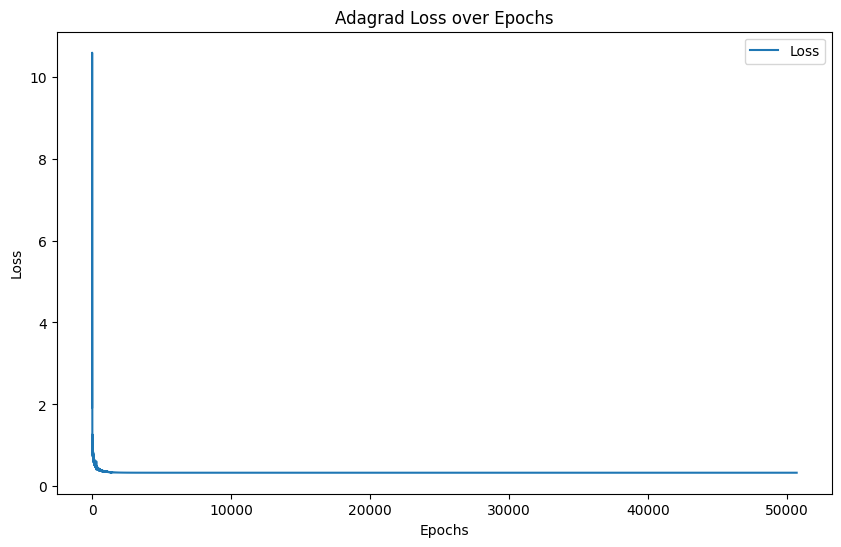

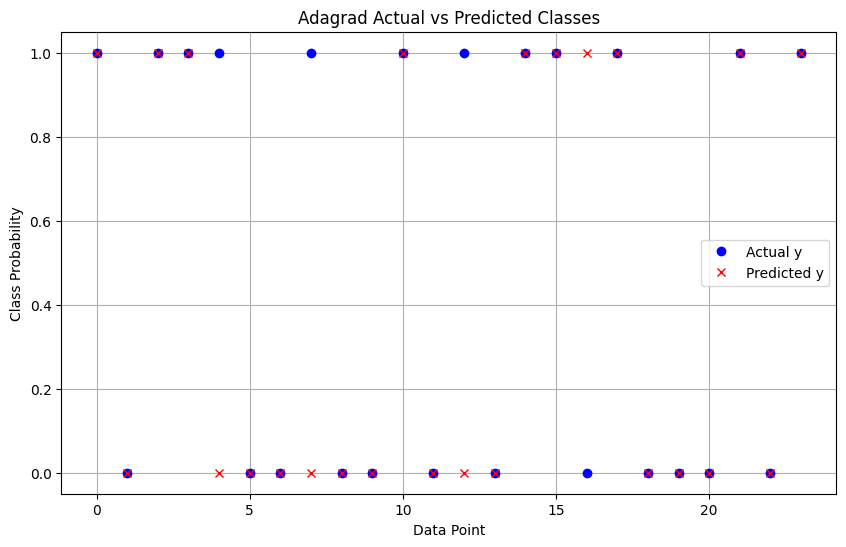

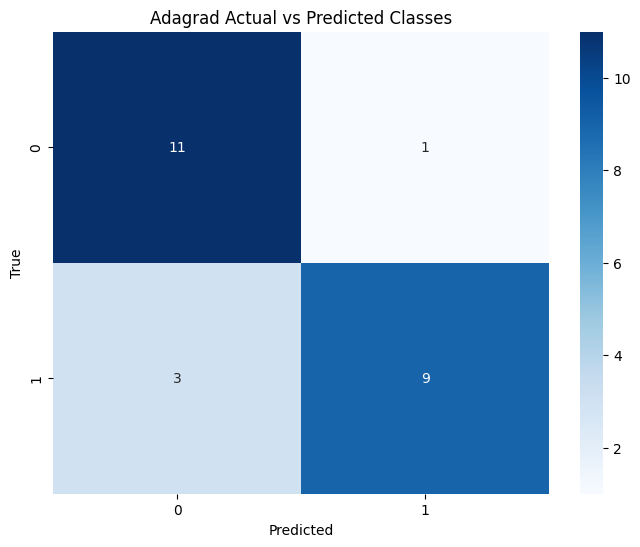

In [ ]:
degree = 2
maxEpochs = 100000
goal = 0.001
lr = 10
lr_decay = 0
mingrad = 1e-11
show = 1000
doValidation = False
lambda_reg = 0.01
epsilon = 1e-10
weight_decay = 0


params, perfs, epochs = train_adagrad(X_train, y_train, X_val, y_val, degree, maxEpochs, goal, lambda_reg, lr, weight_decay, lr_decay, epsilon, mingrad, show, doValidation, 6)


# Evaluate the models on test set
X_test_poly = designMatrix(degree, X_test)

THETA = params.reshape((X_test_poly.shape[1], y_encoded.shape[1]))

y_test_pred_adagrad = softmax(np.dot(X_test_poly, THETA))

y_test_pred_adagrad_classes = np.argmax(y_test_pred_adagrad, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_test_pred_adagrad_classes)

print("Adagrad Classification Accuracy: ", accuracy)
plot_loss(perfs, 'Adagrad Loss over Epochs')
plot_predictions(y_test_classes, y_test_pred_adagrad_classes, 'Adagrad Actual vs Predicted Classes')
plot_confussion_matrix(y_test_classes, y_test_pred_adagrad_classes, 'Adagrad Actual vs Predicted Classes')


### *Levenberg-Marquadt*

Initial parameters:  [[ 1.10456736]
 [ 1.30901229]
 [-0.81450177]
 [-0.88161158]
 [-1.33001063]
 [ 1.24284674]
 [ 0.98350158]
 [-0.07320246]
 [-0.90803852]
 [-0.6566171 ]
 [-1.61983794]
 [ 0.32418673]]
Levenberg-Marquardt: Epoch  58 / 10000 , Performance 3.350e-01 / 0.001 , Gradient 7.649e-03 / 1e-11

Levenberg-Marquardt: Maximum LR reached, performance goal was not met 

Levenber-Marquardt Classification Accuracy:  0.5833333333333334


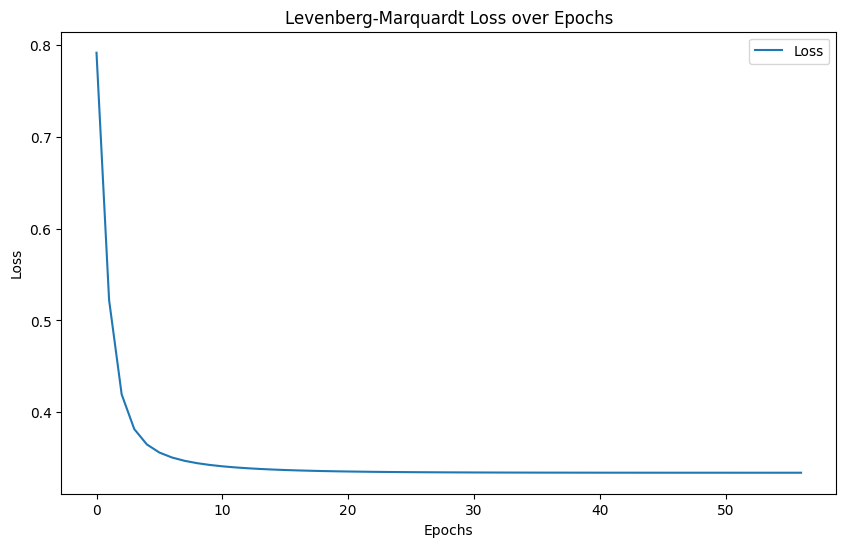

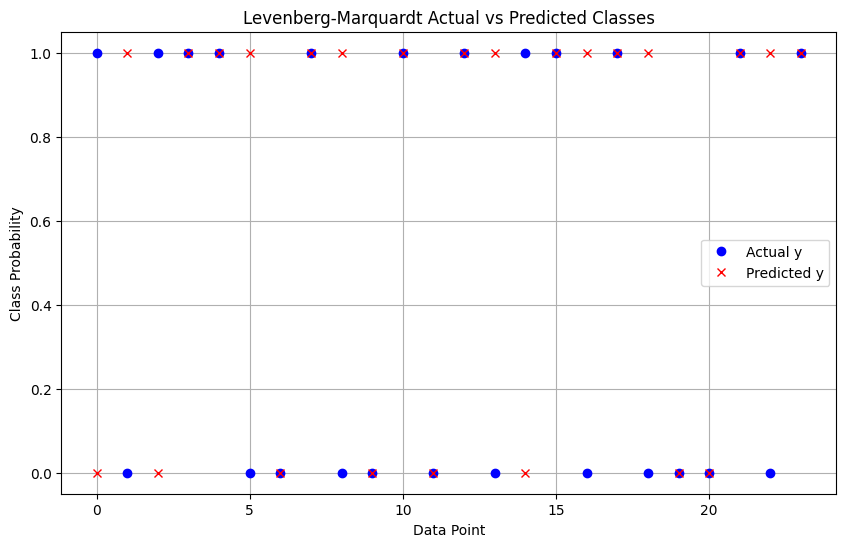

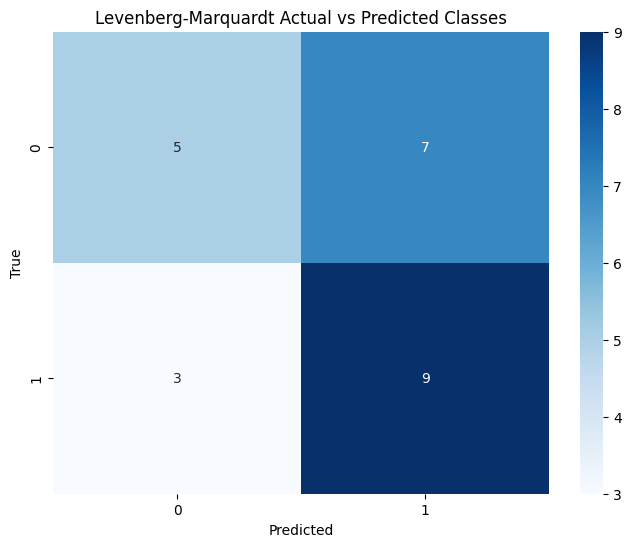

In [ ]:
degree = 2
maxEpochs = 10000
goal = 0.001
lr = 0.01
lr_decay = 0.01
lr_increment = 10
lr_max = 1e10
mingrad = 1e-11
show = 100
doValidation = False
lambda_reg = 0.01
epsilon = 1e-10
weight_decay = 0

params, perfs, epochs = train_lm(X_train, y_train, X_val, y_val, degree, maxEpochs, goal, lambda_reg,  lr, lr_decay, lr_increment, lr_max, mingrad, show, doValidation, 6)


# Evaluate the models on test set
X_test_poly = designMatrix(degree, X_test)

THETA = params.reshape((X_test_poly.shape[1], y_encoded.shape[1]))

y_test_pred_lm = softmax(np.dot(X_test_poly, THETA))


y_test_pred_lm_classes = np.argmax(y_test_pred_lm, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_test_pred_lm_classes)

print("Levenber-Marquardt Classification Accuracy: ", accuracy)
plot_loss(perfs, 'Levenberg-Marquardt Loss over Epochs')
plot_predictions(y_test_classes, y_test_pred_lm_classes, 'Levenberg-Marquardt Actual vs Predicted Classes')
plot_confussion_matrix(y_test_classes, y_test_pred_lm_classes, 'Levenberg-Marquardt Actual vs Predicted Classes')


## Dermatology

In [ ]:
# Example usage:
data = pd.read_csv('/content/dermatology.dat', header=None, delimiter=' ')

X = np.array(data.iloc[:, 0:34])
y = np.array(data.iloc[:, 34:])

print(X)
print(y.shape)
encoder = OneHotEncoder(sparse=False)

X = normalize_data(X)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Split the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

[[ 2  2  0 ...  1  0 55]
 [ 3  3  3 ...  1  0  8]
 [ 2  1  2 ...  2  3 26]
 ...
 [ 3  2  2 ...  2  3 28]
 [ 2  1  3 ...  2  3 50]
 [ 3  2  2 ...  3  0 35]]
(366, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### *Adagrad*

Initial parameters:  [[-0.00867493]
 [ 0.19829227]
 [ 1.35494487]
 ...
 [ 0.30874952]
 [ 0.78652993]
 [-0.31763625]]
AdaGrad: Epoch  1000 / 100000 , Performance 8.246e-02 / 0.001 , Gradient 2.561e-03 / 1e-11
AdaGrad: Epoch  2000 / 100000 , Performance 1.976e-02 / 0.001 , Gradient 1.099e-03 / 1e-11
AdaGrad: Epoch  3000 / 100000 , Performance 9.114e-03 / 0.001 , Gradient 5.807e-04 / 1e-11
AdaGrad: Epoch  4000 / 100000 , Performance 6.079e-03 / 0.001 , Gradient 3.257e-04 / 1e-11
AdaGrad: Epoch  5000 / 100000 , Performance 4.992e-03 / 0.001 , Gradient 1.867e-04 / 1e-11
AdaGrad: Epoch  6000 / 100000 , Performance 4.514e-03 / 0.001 , Gradient 1.080e-04 / 1e-11
AdaGrad: Epoch  7000 / 100000 , Performance 4.256e-03 / 0.001 , Gradient 5.933e-05 / 1e-11
AdaGrad: Epoch  8000 / 100000 , Performance 4.088e-03 / 0.001 , Gradient 3.057e-05 / 1e-11
AdaGrad: Epoch  9000 / 100000 , Performance 3.960e-03 / 0.001 , Gradient 1.713e-05 / 1e-11
AdaGrad: Epoch  10000 / 100000 , Performance 3.855e-03 / 0.001 ,

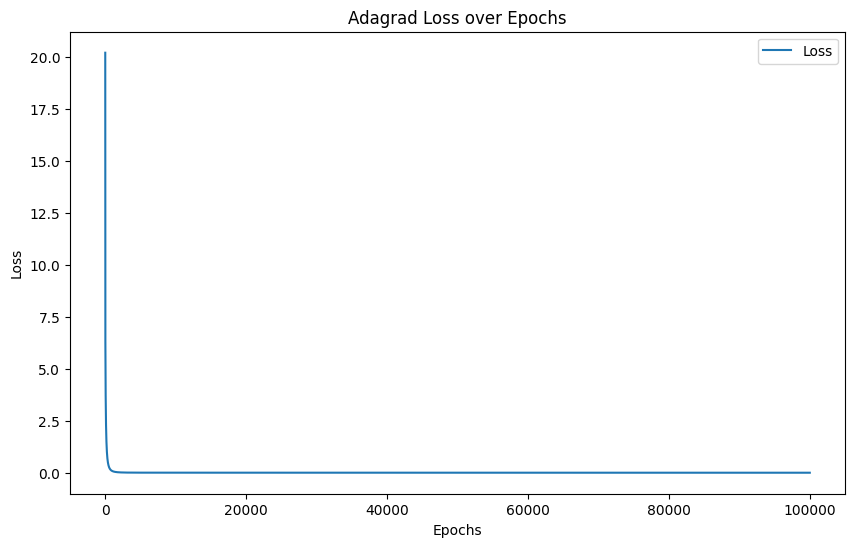

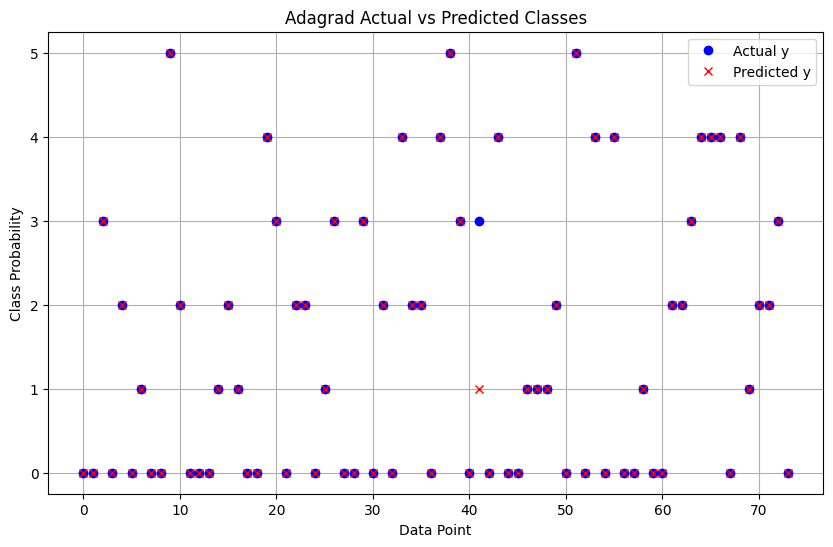

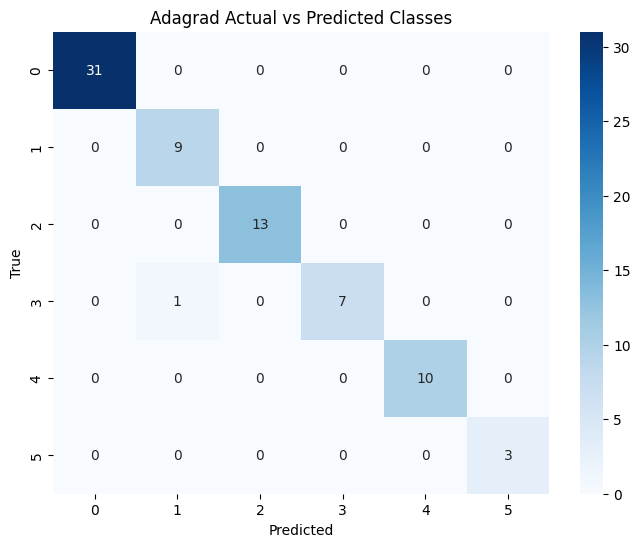

In [ ]:
degree = 2
maxEpochs = 100000
goal = 0.001
lr = 10
lr_decay = 0
mingrad = 1e-11
show = 1000
doValidation = False
lambda_reg = 0.01
epsilon = 1e-10
weight_decay = 0


params, perfs, epochs = train_adagrad(X_train, y_train, X_val, y_val, degree, maxEpochs, goal, lambda_reg, lr, weight_decay, lr_decay, epsilon, mingrad, show, doValidation, 6)


# Evaluate the models on test set
X_test_poly = designMatrix(degree, X_test)

THETA = params.reshape((X_test_poly.shape[1], y_encoded.shape[1]))

y_test_pred_adagrad = softmax(np.dot(X_test_poly, THETA))

y_test_pred_adagrad_classes = np.argmax(y_test_pred_adagrad, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_test_pred_adagrad_classes)

print("Adagrad Classification Accuracy: ", accuracy)
plot_loss(perfs, 'Adagrad Loss over Epochs')
plot_predictions(y_test_classes, y_test_pred_adagrad_classes, 'Adagrad Actual vs Predicted Classes')
plot_confussion_matrix(y_test_classes, y_test_pred_adagrad_classes, 'Adagrad Actual vs Predicted Classes')


### *Levenberg-Marquadt*

In [ ]:
degree = 3
maxEpochs = 10000
goal = 0.001
lr = 0.01
lr_decay = 0.01
lr_increment = 10
lr_max = 1e10
mingrad = 1e-11
show = 100
doValidation = False
lambda_reg = 0.01
epsilon = 1e-10
weight_decay = 0

params, perfs, epochs = train_lm(X_train, y_train, X_val, y_val, degree, maxEpochs, goal, lambda_reg,  lr, lr_decay, lr_increment, lr_max, mingrad, show, doValidation, 6)


# Evaluate the models on test set
X_test_poly = designMatrix(degree, X_test)

THETA = params.reshape((X_test_poly.shape[1], y_encoded.shape[1]))

y_test_pred_lm = softmax(np.dot(X_test_poly, THETA))


y_test_pred_lm_classes = np.argmax(y_test_pred_lm, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_test_pred_lm_classes)

print("Levenber-Marquardt Classification Accuracy: ", accuracy)
plot_loss(perfs, 'Levenberg-Marquardt Loss over Epochs')
plot_predictions(y_test_classes, y_test_pred_lm_classes, 'Levenberg-Marquardt Actual vs Predicted Classes')
plot_confussion_matrix(y_test_classes, y_test_pred_lm_classes, 'Levenberg-Marquardt Actual vs Predicted Classes')


Initial parameters:  [[-0.67129989]
 [ 1.70854216]
 [ 0.30756579]
 ...
 [-0.22038391]
 [ 0.09267332]
 [ 0.58285182]]
